## 图像分类CIFAR-10

1、导入需要的包

In [6]:
import collections # 这个模块实现了特定的目标容器，以提供python标准内奸容器dict，list，set，tuple的替代选择
import math        # math模块提供了许多对浮点数的数学运算函数
import os          #os模块提供了非常丰富的方法用来处理文件和目录，主要提供文件或文件夹的新建、删除、查看等
import shutil      # shutil是python中的高级文件操作模块，与os形成互补关系，提供了移动、复制、压缩、解压等操作，很重要
import pandas as pd # pandas是基于numpy的一种工具，其纳入了大量库和一些标准的数据模型，是数据分析工具
import torch       # 是一个开源的python机器学习库，具备强大的自动求导功能
import torchvision # torchvision是pytorch的一个图形库，主要用来构建计算机视觉模型
from torch import nn #nn模块是神经网络层模块，可以找到任意神经网络层
from d2l import torch as d2l # d2l的学习模块，有很多之前写的方法


2、加载数据地址

In [7]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                               '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')
# 这一段是定义数据的下载地址

demo = False # False为使用完整的数据集

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = 'C:/deeplean/2/cifar-10' # 定义数据集的地址

3、整理数据集

In [8]:
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:               # 'r' 是以只读的方式打开文件
        lines = f.readlines()[1:]              # readlines（）方法用于读取所有行并返回列表 [1:] 则用于去掉文件第一行
    tokens = [l.rstrip().split(',') for l in lines] #  split(',') 是以，为分隔符读取文件, rstrip()是删除字符转末尾指定字符
    return dict(((name, label) for name, label in tokens)) # 返回一个包含键值对的字典，键值对为图片id与对应的分类名称

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv')) # os.oath.join 用于将目录和文件名合成一个路径
print('# 训练样本：', len(labels))
print('# 类别：', len(set(labels.values())))   # set函数是创造一个无序不重复元素集，刚好适合来统计数据集中标签（values）的种类     

# 训练样本： 50000
# 类别： 10


接下来，我们定义reorg_train_valid函数来[将验证集从原始的训练集中拆分出来]。 此函数中的参数valid_ratio是验证集中的样本数与原始训练集中的样本数之比。 更具体地说，令𝑛等于样本最少的类别中的图像数量，而𝑟是比率。 验证集将为每个类别拆分出max(⌊𝑛𝑟⌋,1)张图像。 让我们以valid_ratio=0.1为例，由于原始的训练集有50000张图像，因此train_valid_test/train路径中将有45000张图像用于训练，而剩下5000张图像将作为路径train_valid_test/valid中的验证集。 组织数据集后，同类别的图像将被放置在同一文件夹下。

In [9]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True) # os.makedirs方法用于递归创建剁成目录，题中应有之意即路径中哪一层不存在，则自动创建。
    shutil.copy(filename, target_dir)       # shutil.copy用于将源文件的内容复制到目标文件或目录

def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1] # Counter是统计模块most_common也是配合可以显示类别中最少的样本数，输出数字
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))       # math.fool(x)是将x向下舍到整数，max取（）内的最大值
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):# os.patth.join将（）内合成为一个文件目录，
                                                                   # listdir则返回该目录下的所有文件名称，是一个列表
        label = labels[train_file.split('.')[0]]                   # split('.')是以.分割文件名[0]则是取第一个，1.png到'1'字典返回图片标签
        fname = os.path.join(data_dir, 'train', train_file)        # 返回图片的具体地址目录
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
                                                                   # 这一步是将所有训练图片复制到'train_valid' 目录下并分别以标签分类
        if label not in label_count or label_count[label] < n_valid_per_label:
                            # 如果label('1')不在label_count中或label_count中label键的数量小于训练集最少样本数
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))# 将文件复制到valid验证集中
            label_count[label] = label_count.get(label, 0) + 1      # 将字典label_count中的值重新赋值
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))# 将图片文件到train文件夹下并以标签分类
        
    return n_valid_per_label
            

下面的reorg_test函数用来[在预测期间整理测试集，以方便读取]

In [10]:
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):   # 返回测试集文件名称列表，用for语句读取
        copyfile(os.path.join(data_dir, 'test', test_file), os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))
        # 将测试集文件复制到预定文件夹下 

最后，我们使用一个函数来调用前面定义的函数

In [11]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv')) 
                                                                        # 调用read_csv_labels函数，用来返回图片对应标签这个键值对
    reorg_train_valid(data_dir, labels, valid_ratio)                    # 调用reorg_train_valid函数，用来整理训练集和验证集
    reorg_test(data_dir)                                                # 用来整理测试集

In [12]:
batch_size = 128
valid_ratio = 0.1
#reorg_cifar10_data(data_dir, valid_ratio)

4、图像增广

使用图像增广来解决过拟合的问题，在训练中可以随机水平反转图像，还可以对彩色图像的三个RGB通道执行标准化。

In [13]:
transform_train = torchvision.transforms.Compose([    # transforms.Compose（）类可以将整合多个图片的变换操作
    torchvision.transforms.Resize(40),                # 在Resize()操作可已将图片在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
                                                      # 将输入图像按照随机大小和长度进行裁剪，32为输出图像大小，
                                                      # scale为随机裁剪相当于原图的尺寸，ratio为裁剪后目标像素的宽高比
                                                      #  整个这个操作就是随机定义一个小框开裁剪图片，然后拉成输出32*32的大小。
    torchvision.transforms.RandomHorizontalFlip(),    # 以给定的概率随机水平旋转图像，默认为0.5
    torchvision.transforms.ToTensor(),                #  将给定图形转化为Tensor矩阵
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010]) 
                                    # Normalize函数件数据转换为标准正太分布，其中的参数是图片随机出样计算得来的
])

在测试期间，我们支队图像执行标准化，以消除评估结果中的随机性

In [14]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])

5、读取数据集 

读取有原始图像组成的数据集，每个样本都包括一张图像和一个标签

In [15]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder), transform=transform_train ) 
    for folder in ['train', 'train_valid']]
                                                    # ImageFolder一个数据加载器可以返回一个图片路径和标签
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

指定上面定义的所有图像增广操作，验证集在参数调整时不引入图像增广的随机性

In [22]:
train_valid_ds

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: C:/deeplean/2/cifar-10\train_valid_test\train_valid
    StandardTransform
Transform: Compose(
               Resize(size=40, interpolation=bilinear, max_size=None, antialias=None)
               RandomResizedCrop(size=(32, 32), scale=(0.64, 1.0), ratio=(1.0, 1.0), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [22]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
     dataset, batch_size, shuffle=True, drop_last=True) for dataset in (train_ds, train_valid_ds)]
                                            # torch.utils.data.DataLoader是数据加载器，训练模型的时候使用此函数，把训练数据分成批次
                                            # dataset是加载数据的数据集，batch_size是批量大小，shuffle为True时，会在每个epoch重新打乱数据
                                            # drop_last为True时数据集大小不能被批量整除时删除最后一个不完整的批量
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

6、定义模型

In [24]:
def get_net():
    num_classes = 10                     # num_classes为定义模型的输出数
    net = d2l.resnet18(num_classes, 3)   # 3是输入通道数
    return net

loss = nn.CrossEntropyLoss(reduction="none") # CrossEnteropyLoss()是交叉熵损失函数，损失函数

7、定义训练函数

In [31]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
                       # oprim.SGD实现批量随机梯度下降，输入模型的参数net.parameters,
                       # momentum是动量参数，即在参数更新的时候一定程度上保留之前更新的方向，可以增加稳定性，提高学习速度，摆脱局部最优
                       # weight_decay是权重衰退，也被称为L2正则化，用来防止过拟合问题。
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
                       #  optim.lr_scheduler是学习率调节机制，一般情况下设置随epoch增大而逐渐减小学习率
                       # SteoLR则是每过step_size（lr_period)个epoch做一次更新，gamma(lr_decay)是缝隙系数，即现有学习率相乘得到新的学习率
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']         # 定义一个列表
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend) # 定义画图的参数
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])  #  nn.DataParallel函数来用多个GPU来加速训练 device_ids即参与训练的gpu列表
    for epoch in range(num_epochs):
        net.train()        # 在模型测试阶段使用model(net).train() 让model变成训练模式,主要影响Dropout与BatchNormalization的更新
        metric = d2l.Accumulator(3)   # 实用程序类Accumulator用于对多个变量进行累加 分别用于存储正确预测的数量和预测的总数量。
                                      # 当我们遍历数据集时，两者都将随着时间的推移而累加
        for i, (features, labels) in enumerate(train_iter):
            # enumerate用于将一个可迭代的数据对象 (如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，
            # 一般用在 for 循环当中。 通俗的讲：可迭代指的就是我们可以循环获取其中的每一个元素。如1，（1.png, 'forg')
            timer.start()             # 开始计时
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
                                     #  train_batch_ch13函数为使用多gpu对模型进行训练和评估
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                                                     # % 返回除法的余数， //返回整除数  
                animator.add(epoch + (i + 1)/ num_batches, (metric[0] / metric[2], 
                                                            metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            # d2l.evaluate_accuracy_gpu为使用GPU计算模型在数据集上的精度
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

In [32]:
# def train_batch_ch13(net, X, y, loss, trainer, devices):
#     """用多GPU进行小批量训练"""
#     if isinstance(X, list):
#         # 微调BERT中所需
#         X = [x.to(devices[0]) for x in X]
#     else:
#         X = X.to(devices[0])
#     y = y.to(devices[0])
#     net.train()
#     trainer.zero_grad()
#     pred = net(X)
#     l = loss(pred, y)
#     l.sum().backward()
#     trainer.step()
#     train_loss_sum = l.sum()
#     train_acc_sum = d2l.accuracy(pred, y)
#     return train_loss_sum, train_acc_sum

8、训练和验证模型

现在，我们可以训练和验证模型了，而以下所有超参数都可以调整。 例如，我们可以增加周期的数量。当lr_period和lr_decay分别设置为4和0.9时，优化算法的学习速率将在每4个周期乘以0.9。 

train loss 0.036, train acc 0.988, valid acc 0.868
3594.8 examples/sec on [device(type='cuda', index=0)]


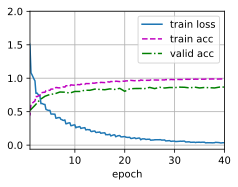

In [33]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 40, 2e-4, 5e-4
                # devices是尝试使用gpu， num_epochs设置40个循环，即训练数据集40遍，
                # lr和wd是随机梯度下降SGD里面的参数，这两个数是常规设置
lr_period, lr_decay, net = 4, 0.9, get_net()
                # lr_period,lr_decay是学习率调整机制里的参数，get_net()则是获取训练的模型Resnet18
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

9、在Kaggle上对测试集进行分类并提交结果

在获得具有超参数的满意的模型后，我们使用所有标记的数据（包括验证集）来重新训练模型并对测试集进行分类。

train loss 0.036, train acc 0.988
3780.3 examples/sec on [device(type='cuda', index=0)]


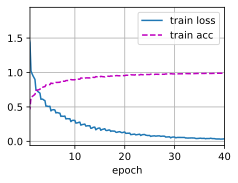

In [35]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)
            # 使用所有训练集重新训练模型

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))  # X.to(devices[0]是将读取的数据放到gpu上运行，
                                   # 将图片参数转换为Tensor然后在模型里计算，得到y_hat，是一个列表*10的数据
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
                                   # .argmax(dim=1)返回y_hat中每一行对应的最大值索引，返回数据为列表
                                   # extend()将（）内的值添加到preds列表中，
                                   # torch默认int是64为的，int32转城32为然后，cpu().numpy()转为cpu上的numpy 
sorted_ids = list(range(1, len(test_ds) + 1)) # 根据test_ds长度设置一个list标签
sorted_ids.sort(key=lambda x: str(x))        # sort用于对列表进行排序，key=lambda x: str(x)则是转换为str排序
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
                                   # pd.DataFrame用以构建一个数据表，id为列表数据，preds为预测的结果
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
                                   # lambda是定义一个匿名函数x，后面是x的内容
                                   # apply函数将preds数字转化为标签
                                   # .classes[x]是根据文件夹名字替换
df.to_csv('submission1.csv', index=False)

In [5]:
a = list[range(1, 5)]
b = range(1, 5)
print(b)

range(1, 5)
